In [ ]:
!mkdir -p real_data
!mkdir -p anime_data

!unzip -q /content/drive/MyDrive/Miyazaki/real_data.zip -d real_data/
!unzip -q /content/drive/MyDrive/Miyazaki/anime_data.zip -d anime_data/

In [ ]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-qgzc3zwz
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-qgzc3zwz
  Created wheel for tensorflow-examples: filename=tensorflow_examples-fb2286d62508f21fcbca26c470843600b3bd769c_-cp37-none-any.whl size=270852 sha256=383217764496337292aefc96591e075ec56004570361259ba608a76f329e2133
  Stored in directory: /tmp/pip-ephem-wheel-cache-icq17o0q/wheels/83/64/b3/4cfa02dc6f9d16bf7257892c6a7ec602cd7e0ff6ec4d7d714d
Successfully built tensorflow-examples


In [ ]:
import tensorflow as tf

import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

real_dir = '/content/real_data'
anime_dir = '/content/anime_data'

In [ ]:
train_real = tf.keras.preprocessing.image_dataset_from_directory(
  real_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(IMG_WIDTH, IMG_HEIGHT),
  batch_size=BATCH_SIZE)

test_real = tf.keras.preprocessing.image_dataset_from_directory(
  real_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(IMG_WIDTH, IMG_HEIGHT),
  batch_size=BATCH_SIZE)

train_anime = tf.keras.preprocessing.image_dataset_from_directory(
  anime_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(IMG_WIDTH, IMG_HEIGHT),
  batch_size=BATCH_SIZE)

test_anime = tf.keras.preprocessing.image_dataset_from_directory(
  anime_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(IMG_WIDTH, IMG_HEIGHT),
  batch_size=BATCH_SIZE)

Found 4235 files belonging to 1 classes.
Using 3388 files for training.
Found 4235 files belonging to 1 classes.
Using 847 files for validation.
Found 9939 files belonging to 1 classes.
Using 7952 files for training.
Found 9939 files belonging to 1 classes.
Using 1987 files for validation.


In [ ]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image[0], size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

def preprocess_image_train(image, label):
  image = random_jitter(image)
  image = normalize(image)
  return image

def preprocess_image_test(image, label):
  image = normalize(image)
  return image

In [ ]:
train_real = train_real.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

train_anime = train_anime.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_real = test_real.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_anime = test_anime.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
sample_real = next(iter(train_real))
sample_anime = next(iter(train_anime))

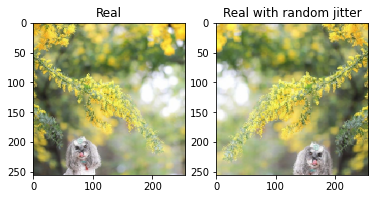

In [ ]:
plt.subplot(121)
plt.title('Real')
plt.imshow((sample_real[0] * 0.5 + 0.5))

plt.subplot(122)
plt.title('Real with random jitter')
plt.imshow((random_jitter(sample_real) * 0.5 + 0.5))

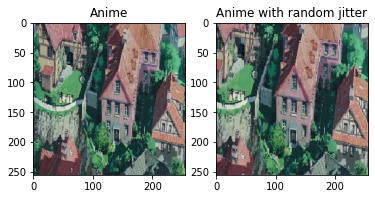

In [ ]:
plt.subplot(121)
plt.title('Anime')
plt.imshow((sample_anime[0] * 0.5 + 0.5))

plt.subplot(122)
plt.title('Anime with random jitter')
plt.imshow((random_jitter(sample_anime) * 0.5 + 0.5))

# Import and reuse the Pix2Pix models

Import the generator and the discriminator used in Pix2Pix via the installed tensorflow_examples package.

The model architecture used in this tutorial is very similar to what was used in pix2pix. Some of the differences are:


*   Cyclegan uses instance normalization instead of batch normalization.
*   The CycleGAN paper uses a modified resnet based generator. This tutorial is using a modified unet generator for simplicity.

There are 2 generators (G and F) and 2 discriminators (X and Y) being trained here.


*   Generator `G` learns to transform image `X` to image `Y`. $(G: X -> Y)$ 


*   Generator `F` learns to transform image `Y` to image `X`. $(F: Y -> X)$
*   Discriminator `D_X` learns to differentiate between image `X` and generated image `X` (`F(Y)`).


*   Discriminator `D_Y` learns to differentiate between image `Y` and generated image `Y` (`G(X)`).



In [ ]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


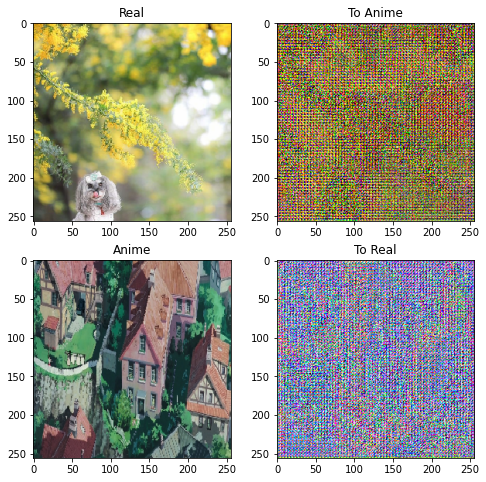

In [ ]:
to_anime = generator_g(sample_real)
to_real = generator_f(sample_anime)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_real, to_anime, sample_anime, to_real]
title = ['Real', 'To Anime', 'Anime', 'To Real']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

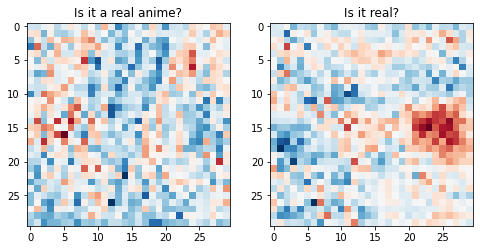

In [ ]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is it a real anime?')
plt.imshow(discriminator_y(sample_anime)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is it real?')
plt.imshow(discriminator_x(sample_real)[0, ..., -1], cmap='RdBu_r')

plt.show()

# Loss functions

In CycleGAN, there is no paired data to train on, hence there is no guarantee that the input `x` and the target `y` pair are meaningful during training. Thus in order to enforce that the network learns the correct mapping, the authors propose the cycle consistency loss.

The discriminator loss and the generator loss are similar to the ones used in pix2pix.

In [ ]:
LAMBDA = 20

In [ ]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [ ]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

Cycle consistency means the result should be close to the original input. For example, if one translates a sentence from English to French, and then translates it back from French to English, then the resulting sentence should be the same as the original sentence.

In cycle consistency loss,


*   Image $X$ is passed via generator $G$ that yields generated image $\hat{Y}$.
*   Generated image $\hat{Y}$ is passed via generator $F$ that yields cycled image $\hat{X}$.

* Mean absolute error is calculated between $\hat{X}$ and $X$.

$forward\,consistency \,loss: X \rightarrow G(X) \rightarrow F(G(X)) \rightarrow \hat{X}$\
$backward\,consistency \,loss: Y \rightarrow F(Y) \rightarrow G(F(Y)) \rightarrow \hat{Y}$


In [ ]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

  return LAMBDA * loss1

As shown above, generator $G$ is responsible for translating image $X$ to image $Y$. Identity loss says that, if you fed image $Y$ to generator $G$, it should yield the real image $Y$ or something close to image $Y$.

If you run the anime-to-real model on a real image or the real-to-anime model on an anime image, it should not modify the image much since the image already contains the target class.

$Identity \,loss = |G(Y) - Y|+|F(X)-X|$

In [ ]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

Initialize the optimizers for all the generators and the discriminators.

In [ ]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Checkpoints

In [ ]:
checkpoint_path = "/content/drive/MyDrive/Miyazaki/checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


#Training

In [ ]:
EPOCHS = 20

In [ ]:
def generate_images(model, test_input):
  prediction = model(test_input)

  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

Even though the training loop looks complicated, it consists of four basic steps:

* Get the predictions.
* Calculate the loss.
* Calculate the gradients using backpropagation.
* Apply the gradients to the optimizer.

In [ ]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.

    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)

  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

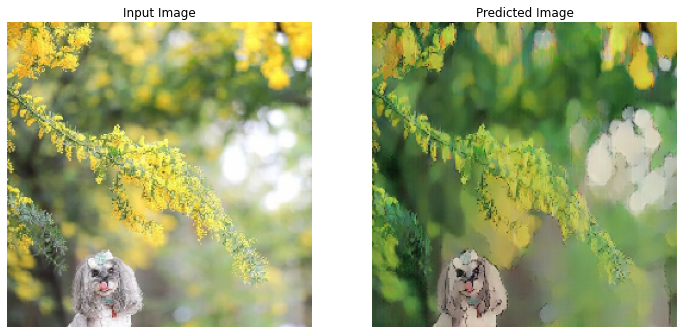

Time taken for epoch 3 is 1462.4328026771545 sec

......

In [ ]:
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_real, train_anime)):
    train_step(image_x, image_y)
    if n % 500 == 0:
      print ('.', end='')
    n += 1

  clear_output(wait=True)
  # Using a consistent image (sample_horse) so that the progress of the model
  # is clearly visible.
  generate_images(generator_g, sample_real)

  if (epoch + 1) % 2 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

# Generate using test dataset

In [ ]:
# Run the trained model on the test dataset
for inp in test_real.take(5):
  generate_images(generator_g, inp)